# **What we are going to cover**
* Getting a `custom dataset` with
PyTorch.
* Data `Preparing` and `visualizing`.
* `Transforming data` for use with a model.
* `Loading custom data` with pre built functions and custom functions.
* Building `FoodVisionMini` to classify images.
* Comparing model with and without `Data Augmentation`.
* Making `Predictions` on custom data.

# Importing and Setting up neccesary things.

In [ ]:
# import libraries.
import torch
from torch import nn

In [ ]:
# Setup device agnostic code.
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Import dataset.

We will use a portion of `The Food-101 Dataset.`


In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder.
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it.
if image_path.is_dir():
  print(f"{image_path} directory already exists. Skiping download... ")
else:
  print(f"{image_path} doesn't exist creating one....")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza_stake_sushi dataset.
with open(data_path/'pizza_stake_sushi.zip', "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading the dataset....")
  f.write(request.content)

# Unzip dataset.
with zipfile.ZipFile(data_path/'pizza_stake_sushi.zip', "r") as zip_ref:
  print("Unzipping the images....")
  zip_ref.extractall(image_path)

print("Done! Now, start writing codes.")

data/pizza_steak_sushi doesn't exist creating one....
Unzipping the images....
Done! Now, start writing codes.


# Data Preparing and Visualizing.

## Data Preparing.
Convert images into tensors.

In [ ]:
import os
def walk_through_dirs(dir_path):
  """Walks through the directories and returning the image contents"""
  for dir_path, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dir_path}'")

In [ ]:
walk_through_dirs(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'


In [ ]:
# Setup train and testing paths.
train_dir = image_path/"train"
test_dir= image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Visualize an image.

In [ ]:
import random
from PIL import Image

# Set seed.
random.seed(42)

# 1. Get all the image paths.
image_path_list = list(image_path.glob("*/*/*.jpg"))
# image_path_list

In [ ]:
# 2. Pick a random image.
random_image_path = random.choice(image_path_list)
print(random_image_path)

data/pizza_steak_sushi/train/steak/560503.jpg


In [ ]:
# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
image_class

'steak'

In [ ]:
# 4. Open image
img = Image.open(random_image_path)

Random image path: data/pizza_steak_sushi/train/steak/560503.jpg
Image Class: steak
Image height: 512
Image width: 512


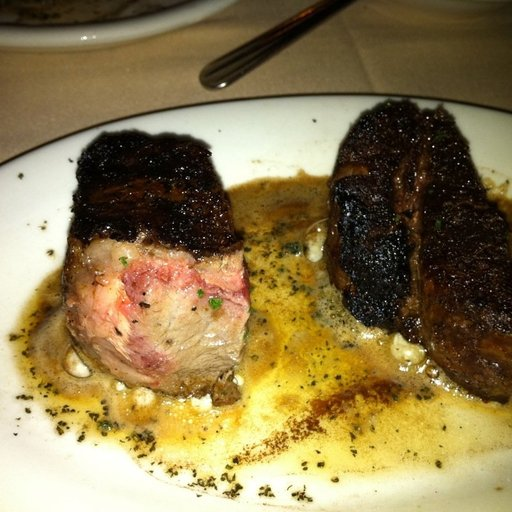

In [ ]:
# 5. Print image metadata.
print(f"Random image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Visualize and image via `matplotlib`

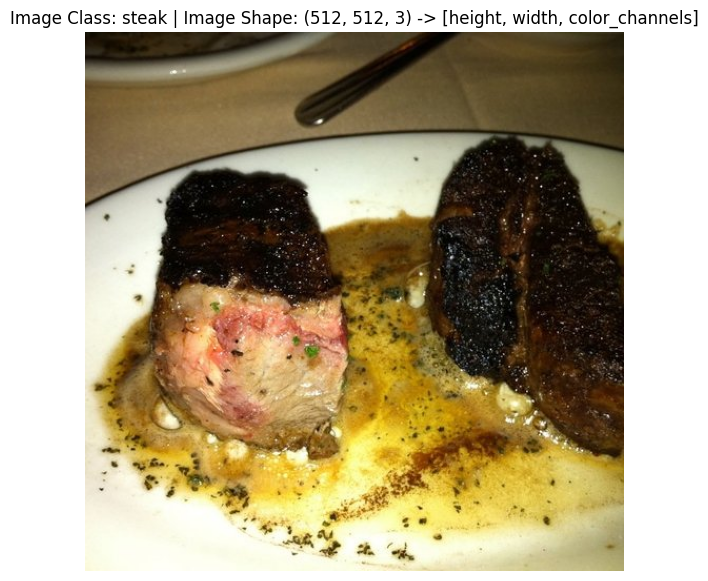

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array.
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


array([[[ 18,  16,   4],
        [ 21,  19,   7],
        [ 24,  22,  10],
        ...,
        [ 46,  41,  22],
        [ 44,  39,  20],
        [ 44,  39,  20]],

       [[ 18,  16,   4],
        [ 21,  19,   7],
        [ 24,  22,  10],
        ...,
        [ 40,  35,  16],
        [ 39,  34,  15],
        [ 38,  33,  14]],

       [[ 19,  15,   4],
        [ 22,  18,   7],
        [ 24,  20,   9],
        ...,
        [ 34,  29,  10],
        [ 33,  28,   9],
        [ 33,  28,   9]],

       ...,

       [[250, 249, 218],
        [250, 249, 218],
        [250, 249, 219],
        ...,
        [178, 172, 114],
        [177, 171, 113],
        [176, 170, 112]],

       [[251, 248, 217],
        [251, 248, 217],
        [249, 248, 217],
        ...,
        [178, 172, 114],
        [177, 171, 113],
        [176, 170, 112]],

       [[251, 248, 217],
        [251, 248, 217],
        [249, 248, 217],
        ...,
        [177, 171, 113],
        [176, 170, 112],
        [175, 169, 111]]], dtype=uint8)
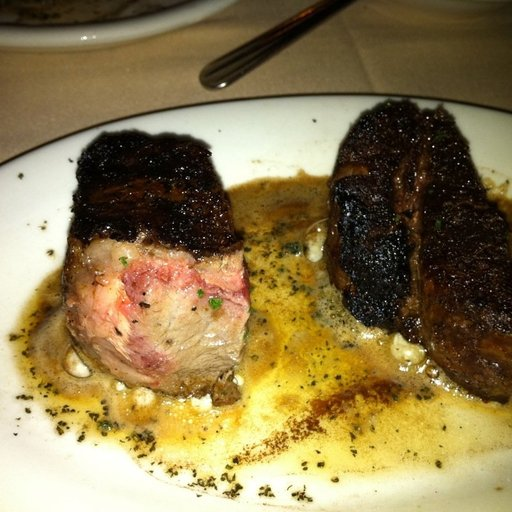

In [ ]:
img_as_array

## Converting images into tensors.

1. Turn target data into tensors.
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`


Transform images with `torchvision.transforms`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with `torchvision.transforms`

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize((64,64)),
    # Flip the images randomly on the horizontal.(Part of data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into tensors.
    transforms.ToTensor()
])

In [ ]:
data_transform(img)

tensor([[[0.1529, 0.1765, 0.2000,  ..., 0.1059, 0.0941, 0.0902],
         [0.1529, 0.1686, 0.1882,  ..., 0.1020, 0.1333, 0.1412],
         [0.1765, 0.1922, 0.2078,  ..., 0.1294, 0.1529, 0.1569],
         ...,
         [0.6392, 0.6275, 0.6667,  ..., 0.9882, 0.9843, 0.9843],
         [0.6706, 0.6863, 0.7020,  ..., 0.9843, 0.9843, 0.9843],
         [0.6902, 0.7098, 0.7255,  ..., 0.9882, 0.9882, 0.9882]],

        [[0.1255, 0.1490, 0.1686,  ..., 0.0784, 0.0706, 0.0627],
         [0.1294, 0.1373, 0.1529,  ..., 0.0706, 0.1020, 0.1020],
         [0.1451, 0.1529, 0.1647,  ..., 0.0941, 0.1255, 0.1294],
         ...,
         [0.6078, 0.5843, 0.6353,  ..., 1.0000, 0.9922, 0.9843],
         [0.6431, 0.6588, 0.6745,  ..., 0.9961, 0.9922, 0.9843],
         [0.6667, 0.6863, 0.6980,  ..., 0.9922, 0.9882, 0.9843]],

        [[0.0549, 0.0706, 0.0784,  ..., 0.0275, 0.0196, 0.0196],
         [0.0549, 0.0588, 0.0627,  ..., 0.0196, 0.0431, 0.0510],
         [0.0667, 0.0667, 0.0745,  ..., 0.0431, 0.0745, 0.

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [ ]:
data_transform(img).dtype

torch.float32

### Visualize image. [OPTIONAL]

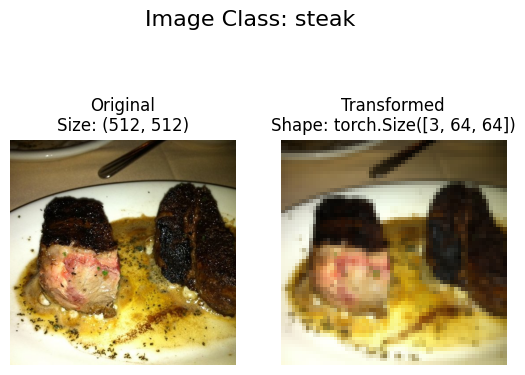

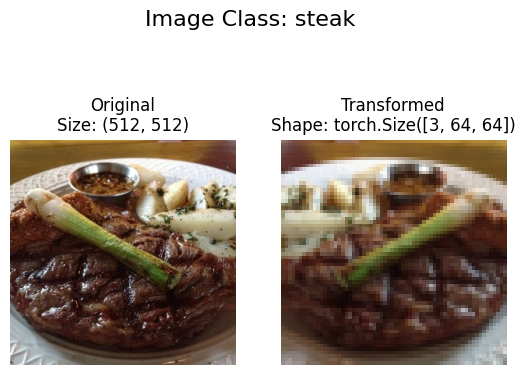

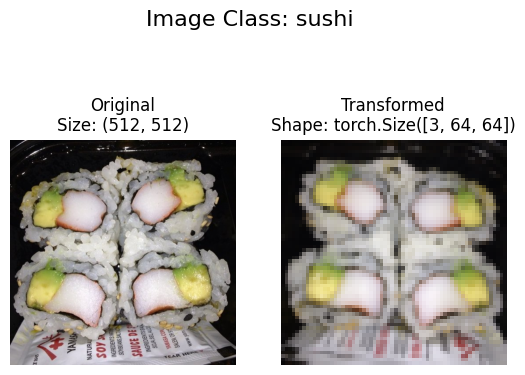

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image.
      transfomed_image = transform(f) # NOTE: we will need to change shape.
      ax[1].imshow(transfomed_image.permute(1,2,0))
      ax[1].set_title(f"Transformed\nShape: {transfomed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Image Class: {image_path.parent.stem}", fontsize=16, y=1)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## Loading all of our images and turning them into tensors with `torchvision.datasets.ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root= train_dir,
                                  transform=data_transform, # A transform for the data.
                                  target_transform=None) # A transform for the label/target.

test_data = datasets.ImageFolder(root = test_dir,
                                 transform=data_transform,
                                 target_transform=None)

print(f"For Training Dataset:\n{train_data}\n")
print(f"For Testing Dataset:\n{test_data}")

For Training Dataset:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

For Testing Dataset:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# Get class names as a list.
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# FGet class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the length of our dataset.
len(train_data), len(test_data)

(225, 75)

In [ ]:
# train_data.samples
# train_data.targets

## Visualize the transformed loaded images.


In [ ]:
# Index on the train_data Dataset to get a single image and label.
img, label = train_data[0][0], train_data[0][1]
img, label
print(f"Image Tensor:\n {img}")
print(f"Image Shape:\n {img.shape}")
print(f"Image datatype:\n {img.dtype}")
print(f"Image Label:\n {label}")
print(f"Label Datatype:\n {type(label)}")

Image Tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [ ]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [C, H, W]
New shape: torch.Size([64, 64, 3]) -> [H, W, C]


(-0.5, 63.5, 63.5, -0.5)

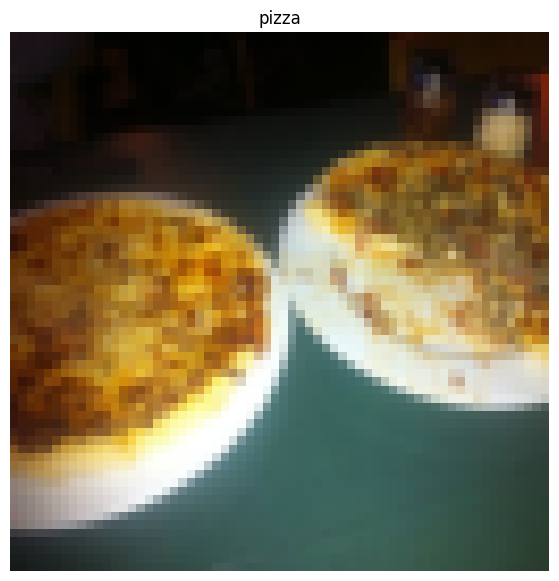

In [ ]:
# Rearrange the order of dimension.
img_premute = img.permute(1,2,0)

# Print out different shapes.
print(f"Original shape: {img.shape} -> [C, H, W]")
print(f"New shape: {img_premute.shape} -> [H, W, C]")

# Plot the image.
plt.figure(figsize=(10,7))
plt.imshow(img_premute)
plt.title(class_names[label])
plt.axis(False)

## Turn loaded images into DataLoader.

Turns our datasets into iterable. And `batch` our images.

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Turn train and test datasets into DataLoader.
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1, # How many CPU cores that will be used to load your data.
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7af14de6e6e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7af14de6dc90>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

225/BATCH_SIZE = 8

In [ ]:
len(train_data), len(test_data)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape} -> [B, C, H, W]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) -> [B, C, H, W]
Label Shape: torch.Size([1])


## Other forms of transformation. [Data Augmentation]

The process of artificailly adding diversity to the training data. Makes the model more generalizable to the `unseen data`.

`LINK:` https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [ ]:
# Using Trivial Augment.
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
                                    ])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
                                    ])

In [ ]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/1976160.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/355715.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/234626.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/914570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1225762.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/830007.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/421476.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2825100.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1413972.jpg')]

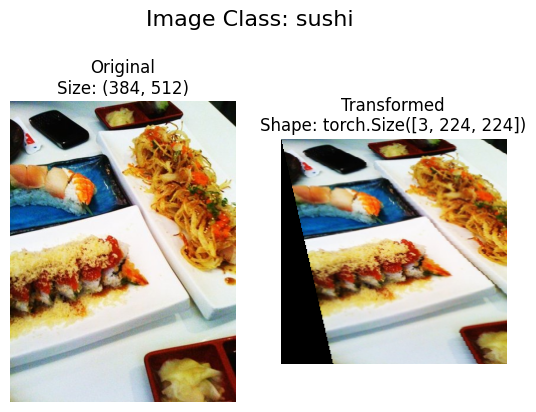

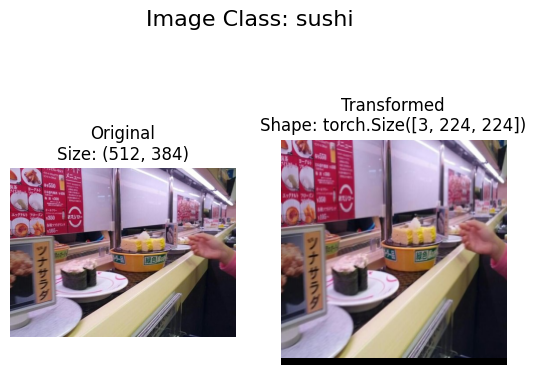

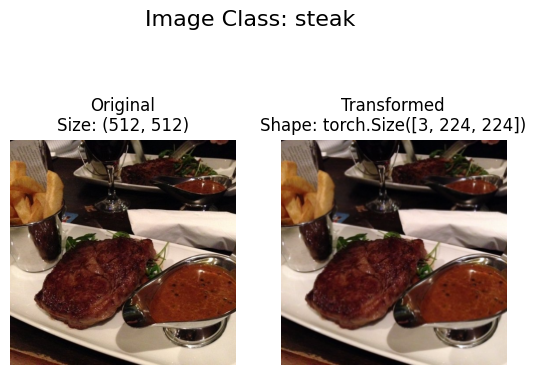

In [ ]:
# Plot random images.
plot_transformed_images(image_paths = image_path_list,
                        transform = train_transform,
                        n=3,
                        seed=None)

# Creating a Baseline Model.

## Model 0: TinyVGG without data augmentation.

### Creating transforms and loading model_0 (just for practicing)

In [ ]:
# Create simple transform.
simple_transform = transforms.Compose([
                              transforms.Resize((64,64)),
                              transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data.
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

In [ ]:
# 2. Turn data into dataloaders.
import os
from torch.utils.data import dataloader

# 3. Setup batch size and number of workers.
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# 4. Create Dataloaders.
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### Creating Baseline model.

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer.
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
       nn.Flatten(),
       nn.Linear(in_features=hidden_units*13*13,
                 out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    # print(x.shape)
    x = self.conv_block2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # Or we can do the forward pass more efficiently.
    # return self.classifier(self.conv_block2(self.conv_block1(x)))

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
)

model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
# Get a single image batch.
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Doing a dummy forward pass on a single pass to test the model.
model_0(image_batch)

# This will output: (32 x 2560) and (10 x 3). We need to match the shape.
# That's why we are doing a dummy forward pass.

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

We can also use a pacakage instead of dummy forward pass.

In [ ]:
# Install torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Setting up train and test functions for Baseline model.

Create customized functions for training and testing.
`train_step` - for training.
`test_step` - for testing.

Creating `train_step`

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put the model in train mode.
  model.train()

  # Setup train loss and accuracy.
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches.
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device.
    X, y = X.to(device), y.to(device)

    # 1. Forward pass.
    y_pred = model(X)

    # 2. Calculate the loss.
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward.
    loss.backward()

    # 5. Optimizer step.
    optimizer.step()

    # Calculate  accuracy metric.
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch.
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

Creating `test_step`

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put the model in eval mode.
  model.eval()

  # Setup test_loss and accuracy.
  test_loss, test_acc = 0, 0

  # Turn on inference mode.
  with torch.inference_mode():
    # Loop through DataLoader batches.
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device.
      X, y = X.to(device), y.to(device)

      # 1. Forward pass.
      test_pred_logits = model(X)

      # 2. Calculate the loss.
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy.
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch.
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss, test_acc

Creating the whole training function.

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function.
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  # Create empty resuls dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps.
  print("Initializing training....")
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print what's happening.
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary.
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  # 6. Return the results after training.
  print("Training Done.....")
  return results

### Training model.

Pick up loss and optimizer.

In [ ]:
# Set random seed.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs.
EPOCHS = 5

# Create an instance of the class.
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

# Setup loss and optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

# Start the timer.
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS)

end_time = timer()
print(f"Total training time: {end_time - start_time:0.3f} seconds")

Initializing training....


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0842 | Train acc: 0.3984 | Test loss: 1.0608 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0654 | Test acc: 0.5644
Training Done.....
Total training time: 19.081 seconds


### Plot the loss curve.

In [ ]:
# Get the model_0 results keys.
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
from typing import Dict, List

def plot_loss_curve(results: Dict[str,List[float]]):
  """Plots the loss curve"""
  # Get the loss values.
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy.
  train_accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Keep track of epochs.
  epochs = range(len(results["train_loss"]))

  # Plot the loss curve.
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label="Train Loss")
  plt.plot(epochs, test_loss, label="Test Loss")
  plt.title("Loss Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  # Plot the accuracy.
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label="Train Accuracy")
  plt.plot(epochs, test_accuracy, label="Test Accuracy")
  plt.title("Accuracy Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend();

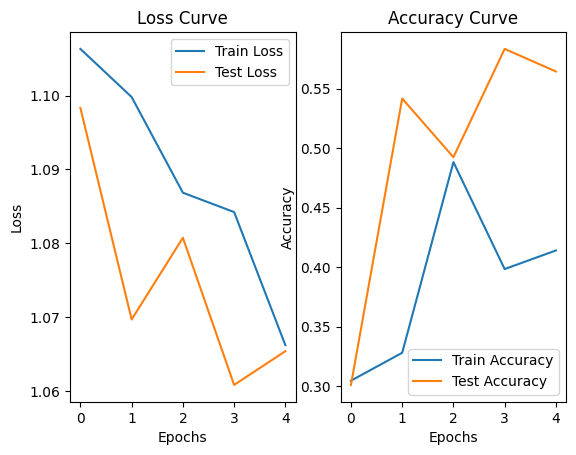

In [ ]:
plot_loss_curve(model_0_results)

## Some informations
Main problems in training are overfitting and underfitting. This can be known from `Loss Curves`.

* **How to deal with overfitting**:
1. Get more data.
2. Data Augmentation.
3. Better data.
4. Use transfer learning.
5. Simplify the model.[Reduce the number of layers or reduce number of hidden units].
6. Use learning rate decay.[Slowly decrease the learning rate as model trains.]
7. Use early stopping.

* **How to deal with underfitting:**
1. Add more layers or hidden units.
2. Tweak the learning rate.
3. Train for longer.
4. Use transfer learning.
5. Use less regularization.


## Model 1: TinyVGG using data augmentation.

### Training transforming with trivial augment.

In [ ]:
# Create training transform
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### Create train and test dataset with `DataLoader` with data augmentation.

In [ ]:
# Turn image folders into dataset.
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_augmented = datasets.ImageFolder(root=test_dir,
                                           transform=test_transform_simple)

### Turn datasets into DataLoader.

In [ ]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

### Construct and train model 1

In [ ]:
# Create model_1 and send it to device agnostic code.
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
# Set random seeds.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the epochs
NUM_EPOCHS = 5

# Setup loss function.
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer.
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start timer.
from timeit import default_timer as timer
start_time = timer()

# Train model_1.
model_1_results = train(model=model_1,
                    train_dataloader=train_dataloader_augmented,
                    test_dataloader=test_dataloader_simple,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time - start_time:0.3f} seconds")

Initializing training....


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1261 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0712 | Train acc: 0.4258 | Test loss: 1.1593 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1253 | Train acc: 0.3047 | Test loss: 1.1581 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0865 | Train acc: 0.4258 | Test loss: 1.1554 | Test acc: 0.3333
Training Done.....
Total training time: 14.338 seconds


We see `Data Augmentation` is not working also.

### Plot the loss curves.

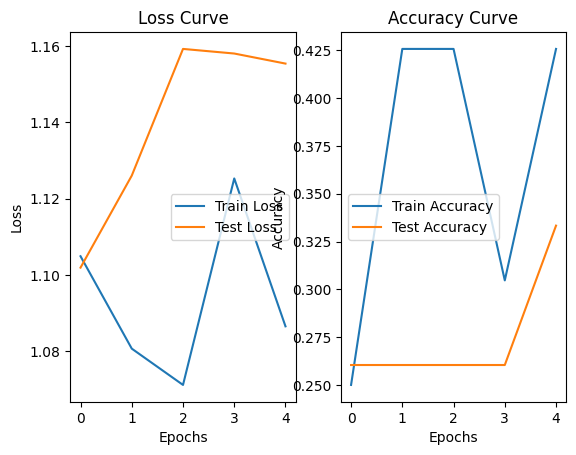

In [ ]:
plot_loss_curve(model_1_results)

## Comparing `model_0` and `model_1`

After evaluating modeling experiments. We are comapring two models.
1.   Hard Coding.
2.   `PyToch + Tensorboard` : https://pytorch.org/docs/stable/tensorboard.html
3. `Weights and Bias` : https://wandb.ai/site/articles/intro-to-mlops-machine-learning-experiment-tracking

4. `MLFlow` : https://mlflow.org/



### Hard Coding.

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

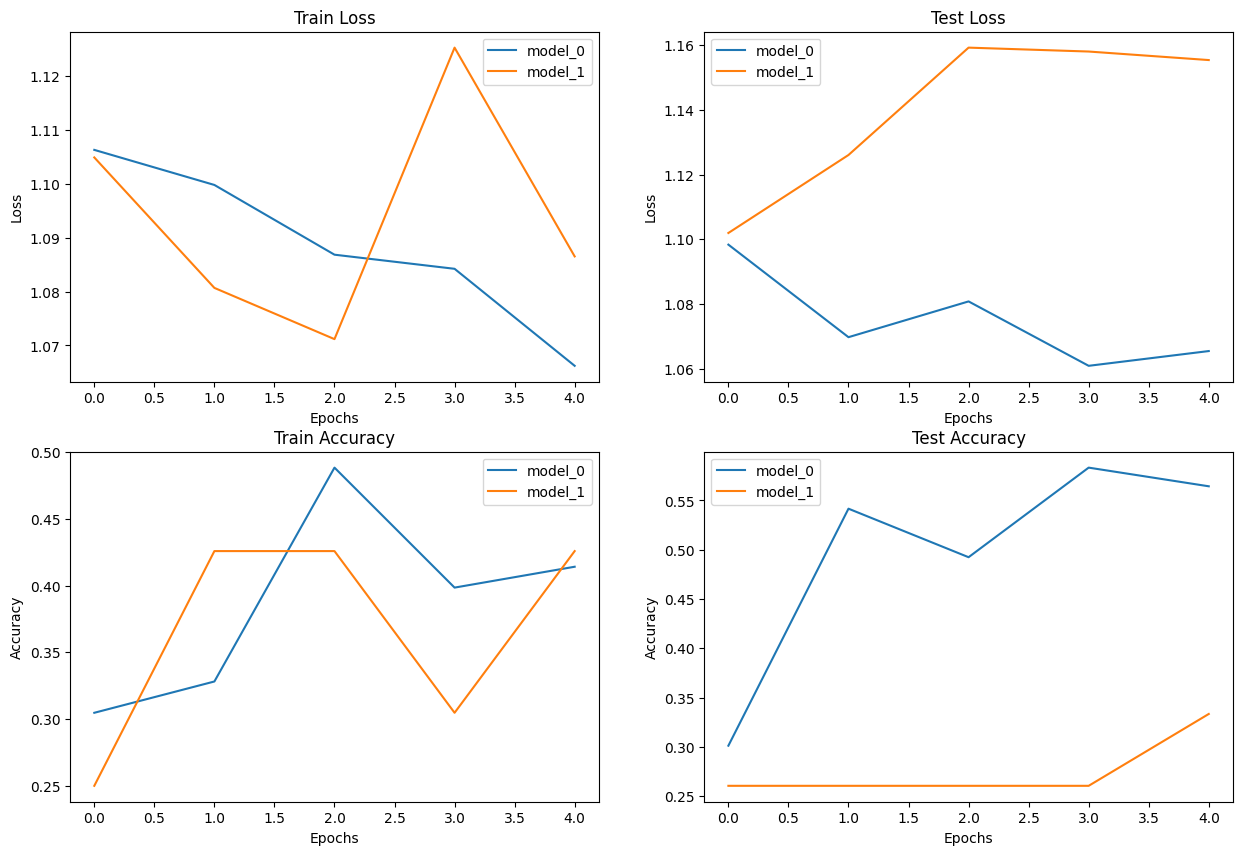

In [ ]:
# Setup a plot.
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss.
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="model_0")
plt.plot(epochs, model_1_df["train_loss"], label="model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

# Plot test loss.
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="model_0")
plt.plot(epochs, model_1_df["test_loss"], label="model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

# Plot train accuracy.
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="model_0")
plt.plot(epochs, model_1_df["train_acc"], label="model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# Plot test accuracy.
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="model_0")
plt.plot(epochs, model_1_df["test_acc"], label="model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

We see model_1 is overfitting in Test Loss curve. So data augmentation wasn't the best choice.

# Making a prediction on a custom image.

## Downloading the custom image

In [ ]:
# Download a custom image.
import requests

# Setup custom image path.
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist.
if not custom_image_path.exists():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}....")
    f.write(request.content)
    print("Download done.")
else:
  print(f"{custom_image_path} already exists, skipping download....")

data/04-pizza-dad.jpeg already exists, skipping download....


## Loading the custom image with PyTorch.
We have to make sure the custom image is in the same format as the data our model was trained on.

- `In tensor form with dtype(torch.float32)`
- `Of shape 64 x 64 x 3`
- `On the right device `

In [ ]:
import torchvision

# Read in custom image.
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

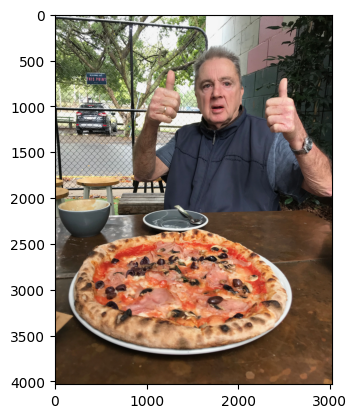

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [ ]:
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape:\n {custom_image_uint8.shape}")
print(f"Custom image datatype:\n {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape:
 torch.Size([3, 4032, 3024])
Custom image dat

## Setting the custom image to desired format.

In [ ]:
# Changing the numbers from integer to float in range of 0  and 1.
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
# Create transform pipeline to resize image.
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transform target image.
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes.
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


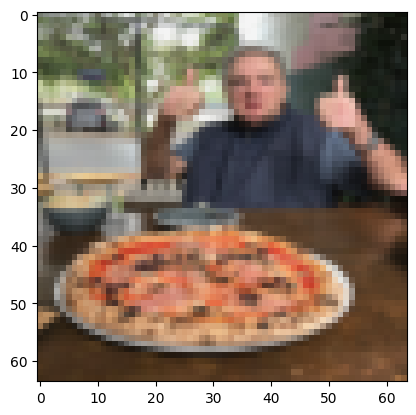

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

Totally disaster. LMAO

In [ ]:
# Making a prediction.
# This will error no batch_size.
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

## Making Prediction

* Load the image and turn it into tensor.
* Make sure the images are in same datatype as the model.
* Make sure the image was the same shape as data the model was trained on.
* Make sure the image was on same device as our model.

In [ ]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
# Making a prediction.
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[ 0.0780,  0.0379, -0.2067]])

In [ ]:
class_names

['pizza', 'steak', 'sushi']

### Convert the logits `custom_image_pred` to predcition labels.

In [ ]:
# Logits -> pred_probs.
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

# pred_probs -> pred_labels.
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)

custom_image_pred_label

tensor([0])

In [ ]:
class_names[custom_image_pred_label]

'pizza'

### Functionizing image prediction.

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """
  Make a prediction on a target image with a trained model and plots the
  image and predictions.
  """
  # Load in the image.
  target_image = torchvision.io.read_image(image_path).type(torch.float32)/255

  # Transform the image.
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device.
  model.to(device)

  # Turn on eval/inference mode.
  model.eval()
  with torch.inference_mode():
    # Add extra dimension to the image.
    target_image = target_image.unsqueeze(dim=0)

    # Make a prediction.
    target_image_pred = model(target_image.to(device))

  # Convert the logits -> prediction probabilites.
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probabilities -> prediction labels.
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image and prediction.
  plt.imshow(target_image.squeeze().permute(1,2,0)) # Remove batch dimension and rearrange.
  if class_names:
    plt.title(f"Prediction: {class_names[target_image_pred_labels.cpu()]} | Probability: {target_image_pred_probs.max().cpu():.3f}")
    plt.axis(False);
  else:
    title = f"Prediction: {target_image_pred_labels.cpu()} | Probability: {target_image_pred_probs.max().cpu():.3f}"
    plt.axis(False)

### Using functionized fucntion to make prediction.

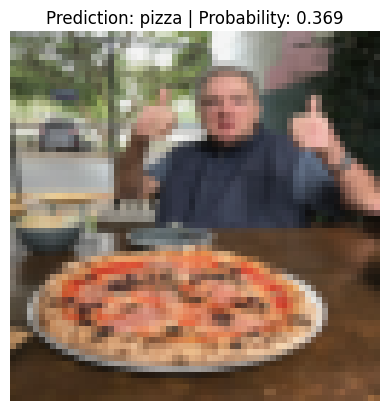

In [ ]:
# Pred on our custome image.
pred_and_plot_image(model=model_1,
                image_path=custom_image_path,
                class_names=class_names,
                transform=custom_image_transform,
                device=device)